# StarEightyTwo + Mapping Prejudice: An Inter-rater Reliability Project

In [9]:
import os
os.chdir('/Users/jake/Documents/stareightytwo/projects/mapping_prejudice/assets/data')

from collections import Counter
from itertools import combinations
import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_similarity_score, cohen_kappa_score

def handle_zero_division(x, y):
    try:
        return x/y
    except ZeroDivisionError:
        return None

### Begin by reading in the data...

In [18]:
df = pd.read_excel('mp_data.xlsx')

## Exploratory analysis
### Classifications over time
Below, we can see a significant spike in classifications after the most recent Star Tribune article highlighting Mapping Prejudice's work.

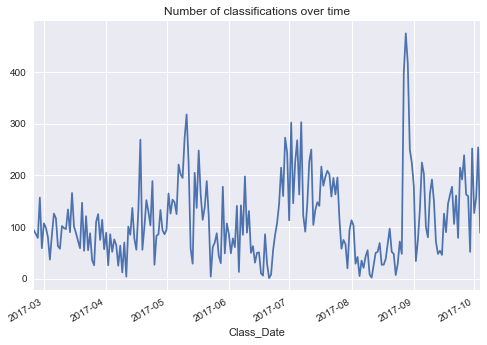

In [19]:
df['Class_Date'] = pd.to_datetime(pd.to_datetime(df['Class_Date']).astype(str).str.split().str[0])

df.groupby(['Class_Date']).size().plot(title='Number of classifications over time')

plt.show()

### How about the number of classifications by user?

In [21]:
gb = df.groupby('User_Name').size().sort_values(ascending=False)

print(gb.head(20))

User_Name
user_222    13550
user_331     1120
user_139     1041
user_161      566
user_304      546
user_256      379
user_452      360
user_248      305
user_531      290
user_520      256
user_235      222
user_513      219
user_485      211
user_528      207
user_234      205
user_171      204
user_24       194
user_124      188
user_13       179
user_377      154
dtype: int64


Wow, there are some star citizens in this volunteer base. How many volunteers does it take to get to 80% of classifications (whether retired or not)?

In [22]:
cumu_sum = np.cumsum(gb)
pareto = cumu_sum/gb.sum()
mask = pareto <= 0.8

pareto = pd.DataFrame({'gb': gb[mask],
                       'cumu_sum': cumu_sum[cumu_sum <= 0.8*gb.sum()],
                       'cumu_perc': pareto[:gb[mask].shape[0]]})

print(pareto)
print(pareto.shape)

           cumu_perc  cumu_sum     gb
User_Name                            
user_222    0.532856     13550  13550
user_331    0.576900     14670   1120
user_139    0.617838     15711   1041
user_161    0.640096     16277    566
user_304    0.661568     16823    546
user_256    0.676472     17202    379
user_452    0.690629     17562    360
user_248    0.702623     17867    305
user_531    0.714027     18157    290
user_520    0.724095     18413    256
user_235    0.732825     18635    222
user_513    0.741437     18854    219
user_485    0.749735     19065    211
user_528    0.757875     19272    207
user_234    0.765937     19477    205
user_171    0.773959     19681    204
user_24     0.781588     19875    194
user_124    0.788981     20063    188
user_13     0.796020     20242    179
(19, 3)


It only takes 19 volunteers to cover 80% of all completed classifications. What about "retired" classifications? What's the coverage like there?

In [23]:
gb = df[df['Retired'] == 'Retired'].groupby('User_Name').size().sort_values(ascending=False)

cumu_sum = np.cumsum(gb)
pareto = cumu_sum/gb.sum()
mask = pareto <= 0.8

pareto = pd.DataFrame({'gb': gb[mask],
                       'cumu_sum': cumu_sum[cumu_sum <= 0.8*gb.sum()],
                       'cumu_perc': pareto[:gb[mask].shape[0]]})

print(pareto)
print(pareto.shape)

           cumu_perc  cumu_sum    gb
User_Name                           
user_222    0.338259      2541  2541
user_161    0.380724      2860   319
user_304    0.413072      3103   243
user_139    0.442758      3326   223
user_248    0.466853      3507   181
user_331    0.490415      3684   177
user_452    0.513578      3858   174
user_531    0.531017      3989   131
user_256    0.548456      4120   131
user_235    0.565495      4248   128
user_234    0.580937      4364   116
user_513    0.595714      4475   111
user_520    0.609957      4582   107
user_24     0.624201      4689   107
user_171    0.638445      4796   107
user_377    0.649494      4879    83
user_485    0.660410      4961    82
user_391    0.671193      5042    81
user_528    0.681709      5121    79
user_119    0.690761      5189    68
user_13     0.698482      5247    58
user_4      0.705538      5300    53
user_151    0.712460      5352    52
user_101    0.719249      5403    51
user_486    0.724973      5446    43
u

Okay, so 40 (out of 533) volunteers account for 80% of the retired classifications. That's a little better, for our purposes.

# What about overlap between classifications?
Specifically, is there enough across-rater coverage to warrant an inter-rater reliability examination?

In [24]:
overlap = {}

for user, user_df in df.groupby('User_Name'):
    overlap[user] = {}
    user_img_seen = set(user_df['Image_ID'])

    for other_user, other_df in df[df['User_Name'] != user].groupby('User_Name'):
        other_user_img_seen = set(other_df['Image_ID'])

        # Set intersection between what the user's seen and what the other user has seen
        common = user_img_seen & other_user_img_seen
        
        # Keep track of classifications in common and the number of in-common classifications (images seen)
        overlap[user][other_user] = {'common': common,
                                    'number': len(common)}

But wait! There's more (observations than we need). The approach above produces duplicates - the order in which *you and I* versus *I and you* share elements doesn't matter. We could have used `itertools.combinations`, but the following approach produces the same results:

In [25]:
# Remove duplicates... proxy for order-2 combinations
overlap_deduped = {}
for user in overlap:
    for other_user, values in overlap[user].items():
        # +1 for unordered keys
        overlap_deduped[frozenset((user, other_user))] = values
        
# Same thing!
assert len(overlap_deduped) == len(list(combinations(set(df['User_Name']), 2)))

Looking below, we can see a lot of user-other user combinations don't result in any overlap. Let's validate that every user has at least one overlap with another volunteer:

In [26]:
numbers = [overlap_deduped[fset]['number'] for fset in overlap_deduped]

sorted(Counter(numbers).most_common()[:10], key=lambda x: (-x[1], x[0]))

[(0, 139006),
 (1, 1835),
 (2, 342),
 (3, 160),
 (4, 99),
 (5, 47),
 (6, 42),
 (7, 26),
 (10, 18),
 (11, 14)]

Well, let's at least check that all users have at least *one* overlap (i.e. one common image classified) with another user.

In [27]:
# All users have at least one overlap... use the original `overlap` with duplicates for this one
anything_for_user = [1 if any(overlap[user][other_user]['number'] > 0 
                              for other_user in overlap[user]) 
                     else 0 for user in overlap]

# This shouldn't raise an exception... meaning that every user has seen at least one image that someone else has seen
assert all(x == 1 for x in anything_for_user)

Great! How about some descriptive statistics around the number of overlaps by user?

In [28]:
# Number of overlaps per user
n_overlaps_by_user = {user: sum(overlap[user][other_user]['number']
                                for other_user in overlap[user])
                      for user in overlap}

overlaps_no_dict = [n_overlaps for user, n_overlaps in n_overlaps_by_user.items()]

print('Summary statistics: number of overlaps with other users')
print('Mean: {}'.format(round(np.mean(overlaps_no_dict), 2)))
print('Median: {}'.format(np.median(overlaps_no_dict)))
print('Standard deviation: {}'.format(round(np.std(overlaps_no_dict), 2)))

Summary statistics: number of overlaps with other users
Mean: 59.35
Median: 6.0
Standard deviation: 529.32


There's definitely a lot of variation in the number of overlaps for each user. That's again due to one user who drives much of the classifications for this project. That low median isn't all that promising, though, but I suppose it's in line with the Pareto information we observed above.

Let's look more at the distribution of overlaps.

In [29]:
n_overlaps_min, n_overlaps_max = min(overlaps_no_dict), max(overlaps_no_dict)

# Number of users with at least n common classifications
users_with_at_least = {n: sum(1 for i in overlaps_no_dict if i >= n)
                           for n in set(overlaps_no_dict)}

print('Number of users with at least...')
print('\n'.join('{} overlap(s): {} users'.format(overlaps, n_users) 
                for overlaps, n_users in sorted(users_with_at_least.items(), key=lambda x: -x[1])[:20]))

Number of users with at least...
1 overlap(s): 533 users
2 overlap(s): 482 users
3 overlap(s): 409 users
4 overlap(s): 365 users
5 overlap(s): 330 users
6 overlap(s): 288 users
7 overlap(s): 261 users
8 overlap(s): 239 users
9 overlap(s): 223 users
10 overlap(s): 205 users
11 overlap(s): 190 users
12 overlap(s): 181 users
13 overlap(s): 177 users
14 overlap(s): 170 users
15 overlap(s): 163 users
16 overlap(s): 160 users
17 overlap(s): 156 users
18 overlap(s): 149 users
19 overlap(s): 141 users
20 overlap(s): 133 users


We can see that the majority of users have fewer than ten images in common with other users. But not everything is doom and gloom! 133 users share at least twenty images, so that's probably good enough to get started with! Spoiling the surprise a bit, nearly 60 users share at least 50 overlaps. For what we're trying to accomplish, that ought to be a great start.

### Overlap heatmap for the most frequent volunteers

In [15]:
# Heatmap of top n volunteers' overlap totals
n = 50

# Original number of classifications by user
top_n_volunteers = gb.index[:n]

# Every volunteer has been compared with every other volunteer
# so all of these should be valid keys in `overlap_deduped`
top_vol_combos = list(map(frozenset, combinations(top_n_volunteers, 2)))

# Empty dataframe to fill with number of overlaps between volunteers
heatmap_df = pd.DataFrame(data=None, columns=top_n_volunteers, index=top_n_volunteers)

# Fill-in the table to eventually be plotted
for vol, other_vol in top_vol_combos:
    fs_key = frozenset((vol, other_vol))
    heatmap_df.loc[vol, other_vol] = overlap_deduped[fs_key]['number']
    
# In the case of no overlaps, populate zero
heatmap_df.fillna(0, inplace=True)

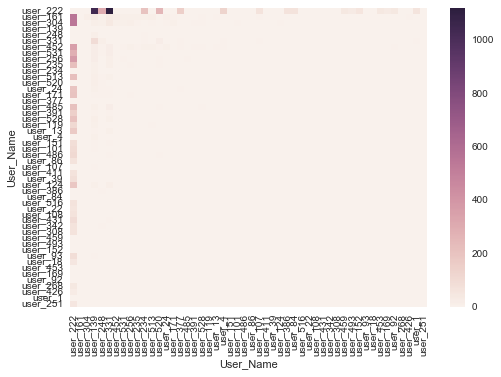

In [16]:
# Example from here: https://seaborn.pydata.org/generated/seaborn.heatmap.html
ax = sns.heatmap(heatmap_df)

plt.show()

In [17]:
# "Save" `df`, because we're going to make some modifications below
orig = df.copy(deep=True)

### Let's first take a look at the top *n* volunteers and how well they agree with each other.
Some volunteers have viewed the same image multiple times. For the sake of simplicity, each volunteer's "answer" for each image they've seen will be their most recent classification. This isn't a bad assumption, as I would venture to say volunteers have improved throughout their time classifying deeds.

In [18]:
df = orig.copy(deep=True)

df.sort_values('Class_Date', ascending=False, inplace=True)

# filter to just look at the top n volunteers
df = df[df['User_Name'].isin(top_n_volunteers)]

df.drop_duplicates(subset=['User_Name', 'Image_ID'], inplace=True)

Now look at overlap *and agreement* between these volunteers... This is what we came here for...

In [19]:
overlap = []

for user, user_df in df.groupby('User_Name'):
    # Images the main user has seen and associated ratings    
    user_img_seen = {user_df.loc[idx, 'Image_ID']: user_df.loc[idx, 'Match']
                         for idx in user_df.index}
    
    for other_user, other_df in df[df['User_Name'] != user].groupby('User_Name'):
        # Images the other user has seen and associated ratings
        other_user_img_seen = {other_df.loc[idx, 'Image_ID']: other_df.loc[idx, 'Match']
                                 for idx in other_df.index}
        
        # Set intersection between what the user's seen and what the other user has seen
        common = set(user_img_seen) & set(other_user_img_seen)

        # We only care to measure agreement between raters who have seen the same deeds
        if common:
            # Pairs of answers for each deed (image) commonly seen
            together = [(user_img_seen[img], other_user_img_seen[img])
                            for img in common]

            # Used to calculate Cohen's Kappa...
            # Just lists of each user's answers for all deeds shared
            user_vector = [x[0] for x in together]
            other_user_vector = [x[1] for x in together]

            # Can use sklearn.metrics.cohen_kappa_score, 
            #but should go through exercise of actually calculating...
            # http://psych.unl.edu/psycrs/handcomp/hckappa.PDF
            
            # If cohen_kappa_score returns np.nan, then we know each user agreed 100%...
            # but there was no "random chance" component
            
            # https://github.com/scikit-learn/scikit-learn/issues/9624
            # "1 in Cohen's Kappa indicates perfect agreement 
            # with 0 chance of agreement at random.
            # Here there is perfect agreement at random."
            
            # Cohen's Kappa can be zero when one rater 
            # gives the same answer for every subject
            # (e.g. in the case) of a "no" troll
            cohen_kappa = cohen_kappa_score(user_vector, other_user_vector)
                        
            if not np.isnan(cohen_kappa):
                # Set of IDs agreed- and disagreed-upon
                agreements = {img for img in common 
                              if user_img_seen[img] == other_user_img_seen[img]}
                
                disagreements = {img for img in common 
                                 if user_img_seen[img] != other_user_img_seen[img]}
                
                n_common = len(common)
                n_agreements = len(agreements)
                n_disagreements = len(disagreements)

                # Keep track of classifications in common and the 
                # number of in-common classifications (images seen)
                overlap.append(
                    {
                    'user': user,
                    'other_user': other_user,
                    'cohen_kappa': cohen_kappa,
                    'n_in_common': n_common,
                    'user_together_drop_dupe': frozenset((user, other_user)),

                    # The following are relatively more naive measures of reliability...
                    'n_agreements': n_agreements,
                    'n_disagreements': n_disagreements,
                    'perc_agreements': handle_zero_division(n_agreements, n_common),
                    'perc_disagreements': handle_zero_division(n_disagreements, n_common),
                    'agree_disagree_ratio': handle_zero_division(n_agreements, n_disagreements)
                    }
                )

# This `drop_duplicates` call creates some trouble below when grouping on `user`...
# Values in the "user" column for some users 
# will be dropped because they're already captured by drop_dupe

# Consider this example
# df = pd.DataFrame({'user': ['a', 'b', 'c'], 'other_user': ['b', 'a', 'a']})
# df['key_no_dupe'] = list(map(frozenset, df[['user', 'other_user']].values))
# df.drop_duplicates(['key_no_dupe'])
#   other_user user key_no_dupe
#0          b    a      (b, a)
#2          a    c      (c, a)
# `b` won't exist when grouping on 'user'

agreement_df = (pd.DataFrame
                .from_records(overlap))
#                .drop_duplicates(subset=['user_together_drop_dupe']))

/Users/jake/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:350: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Here's a sample of the dataframe we just put together:

In [20]:
agreement_df.sort_values(['n_in_common', 'cohen_kappa'], ascending=False).head()

,agree_disagree_ratio,cohen_kappa,n_agreements,n_disagreements,n_in_common,other_user,perc_agreements,perc_disagreements,user,user_together_drop_dupe
230,12.023256,0.868319,1034,86,1120,user_331,0.923214,0.076786,user_222,"(user_222, user_331)"
425,12.023256,0.868319,1034,86,1120,user_222,0.923214,0.076786,user_331,"(user_331, user_222)"
88,20.687500,0.920297,993,48,1041,user_222,0.953890,0.046110,user_139,"(user_222, user_139)"
213,20.687500,0.920297,993,48,1041,user_139,0.953890,0.046110,user_222,"(user_222, user_139)"
144,41.923077,0.958473,545,13,558,user_222,0.976703,0.023297,user_161,"(user_161, user_222)"


Let's take a look at the most reliable raters, according to Cohen's Kappa:

In [469]:
(agreement_df
 .groupby('user')[['cohen_kappa', 'n_in_common']]
 .agg({'cohen_kappa': np.mean, 'n_in_common': np.sum})
 .sort_values(by=['cohen_kappa', 'n_in_common'], ascending=False)
 .head(10))

,cohen_kappa,n_in_common
user,,
user_493,1.000000,41
user_386,0.981019,85
user_342,0.928968,79
user_431,0.912504,128
user_24,0.901682,271
user_93,0.884328,111
user_124,0.881384,242
user_152,0.867838,62
user_92,0.850912,66


These folks above are some of our best candidates for becoming the "source of truth" when ratings between volunteers become conflicted.

How about the *least* reliable raters?

In [473]:
(agreement_df
 .groupby('user')[['cohen_kappa', 'n_in_common']]
 .agg({'cohen_kappa': np.mean, 'n_in_common': np.sum})
 .sort_values(by=['cohen_kappa', 'n_in_common'], ascending=True)
 .head(10))

,cohen_kappa,n_in_common
user,,
user_1,0.000000,75
user_377,0.141522,204
user_516,0.277762,83
user_453,0.319581,55
user_86,0.330197,94
user_459,0.358878,51
user_391,0.386260,208
user_411,0.438797,87
user_108,0.458786,81


We can see that `user_1` has an average Kappa value of 0.0, meaning that he or she is most likely a troll. After some investigation...

In [478]:
df[df['User_Name'] == 'user_1']

,Retired,User_Name,Class_ID,Class_Date,Match,Image_ID,Racial_Res,City,Addition,Lot,Block,Doc_ID,Grantor,Grantee,Date_Deed,Date_Ex,User_Name_orig
15176,Retired,user_1,63345581,2017-07-12,No,1227_0557_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15188,Not Retired,user_1,63346498,2017-07-12,No,1970_0106_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15187,Not Retired,user_1,63346478,2017-07-12,No,1717_0538_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15186,Retired,user_1,63346352,2017-07-12,No,1607_0147_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15178,Not Retired,user_1,63345598,2017-07-12,No,1486_0217_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15177,Retired,user_1,63345594,2017-07-12,No,1407_0560_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15175,Retired,user_1,63345565,2017-07-12,No,1223_0008_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15160,Retired,user_1,63345152,2017-07-12,No,1049_0565_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15174,Not Retired,user_1,63345552,2017-07-12,No,708_0183_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf
15173,Not Retired,user_1,63345539,2017-07-12,No,2025_0094_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null,uo1554pf


It's plain to see that this person is just saying "no" for every image. Going forward, we'll exclude them from any further rater-reliability exam. That's not to say some of the other lowest-scoring raters aren't trolls, either, but they warrant a little more investigation...

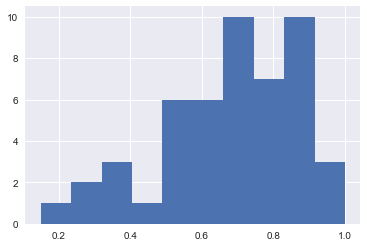

In [479]:
# Want to remove user_1 and any associated rater-rater pairs in which he or she was involved...
agreement_df = agreement_df[agreement_df.index.isin(idx for idx in agreement_df.index 
                                                    if not 'user_1' in agreement_df.loc[idx, 'user_together_drop_dupe'])]

avg_kappa = agreement_df.groupby(['user'])['cohen_kappa'].mean()

avg_kappa.hist()

We see that, on average, most of the raters are pretty reliable! It's subjective, of course, but most statisticians agree that a Kappa value greater than 0.5 indicates "moderate" to "good" agreement. A Kappa of 1 indicates perfect agreement over random chance.

But there are some raters lacking a little bit, near the left side of the distribution:

In [483]:
# Users with whom MP could potentially follow-up for more training...
# Some of these users have seen quite a few images!
gb[gb.index.isin(avg_kappa[(avg_kappa <= 0.5) & (avg_kappa > 0)].index)].to_frame('n_clfs').head(10)

,n_clfs
User_Name,
user_377,83
user_485,82
user_391,81
user_86,42
user_411,40
user_516,37
user_108,34
user_459,29
user_453,26


### The Cohen's Kappa values aren't normalized or scaled in any relative way. We can develop an index based on how reliable a given rater is compared to all other raters, on average

What follows is an attempt to obtain for each rater their "reliability" score, which should be some combination of their average or median Cohen's Kappa value and how many classifications they've done...

In [465]:
print(reliability_df)

          cohen_kappa  n_clfs  cohen_kappa_standardized  agreement_index
user_1       0.000000      57                 -3.071346         0.000000
user_101     0.627774      99                 -0.161731         2.884698
user_107     0.709374      65                  0.216469         2.961202
user_108     0.458786      62                 -0.944958         1.893472
user_119     0.665092     113                  0.011230         3.144148
user_124     0.881384     187                  1.013702         4.610615
user_13      0.685947     179                  0.107887         3.558269
user_139     0.793414    1041                  0.605978         5.512591
user_151     0.525774      93                 -0.634485         2.383121
user_152     0.867838      54                  0.950919         3.461792
user_161     0.825630     560                  0.755294         5.224536
user_169     0.510282      35                 -0.706283         1.814232
user_171     0.699525     204                  0.17

In [462]:
# Number of classifications for each user
num_clfs = df.groupby(['User_Name']).size().to_frame('n_clfs')

# Put together the number of classifications and Cohen's Kappa vlaues for each user
reliability_df = pd.concat((avg_kappa, num_clfs), axis=1)

# Could normalize the Kappa value to see who's significantly more or less agreeable
mean_kappa, std_kappa = reliability_df['cohen_kappa'].mean(), reliability_df['cohen_kappa'].std()

reliability_df['cohen_kappa_standardized'] = (reliability_df['cohen_kappa'] - mean_kappa)/std_kappa

# Probably a good idea to adjust for the number of classifications seen
# Can you think of a better index... I think logarithmically "rewarding"
# more classifications seems to work out nicely... reward a lot initially, but then diminishing returns take over
reliability_df['agreement_index'] = reliability_df['cohen_kappa'] * np.log(reliability_df['n_clfs'])

print(reliability_df.sort_values('agreement_index', ascending=False).head(25))
print('*'*30)
print(reliability_df.sort_values('agreement_index', ascending=False).tail(10))

# Slight positive correlation between Cohen's Kappa (one of our IRR measures) and number of classifications... sig?
print(reliability_df.corr())

          cohen_kappa  n_clfs  cohen_kappa_standardized  agreement_index
user_222     0.828499   13503                  0.768593         7.879583
user_331     0.794800    1120                  0.612404         5.580361
user_139     0.793414    1041                  0.605978         5.512591
user_304     0.830899     546                  0.779716         5.236842
user_161     0.825630     560                  0.755294         5.224536
user_24      0.901682     194                  1.107781         4.749935
user_124     0.881384     187                  1.013702         4.610615
user_520     0.797891     256                  0.626728         4.424446
user_513     0.805964     219                  0.664146         4.343399
user_452     0.735249     360                  0.336396         4.327754
user_234     0.793200     205                  0.604987         4.222212
user_431     0.912504      95                  1.157940         4.155433
user_386     0.981019      65                  1.47

### Of the top *n* raters, how many unique images have they covered?

In [395]:
imgs_covered = set(df[df['User_Name'].isin(top_n_volunteers)]['Image_ID'].dropna())

print('Percentage of images covered by top {} volunteers: {}'
      .format(n, round(len(imgs_covered)/len(set(df['Image_ID'].dropna())), 2)))

Percentage of images covered by top 50 volunteers: 1.0


Great, so we know now that we have 100% coverage across all deeds for the top 50 most prolific (not necessarily - at this point - highest-rated... work on that) volunteers. That means, in the case of a tie, we can defer to the most reliable of those top 50 volunteers.

## Want to try this out yourself? Get the data from [here](http://bit.ly/2hmNJEQ).

In [484]:
#http://psych.unl.edu/psycrs/handcomp/hckappa.PDF
a = ['no', 'no', 'no', 'yes', 'yes', 'yes', 'no',
     'maybe', 'no', 'maybe', 'maybe', 'maybe',
     'maybe', 'maybe', 'maybe']

b = ['no', 'yes', 'no', 'no', 'yes', 'no', 'yes',
     'maybe', 'no', 'maybe', 'maybe', 'yes',
     'maybe', 'maybe', 'maybe']

unique_vals = set(a) | set(b)

contin_tb = pd.DataFrame(data=np.zeros((len(unique_vals), len(unique_vals))),
                         index=unique_vals,
                         columns=unique_vals)

for rater_a_obs, rater_b_obs in zip(a, b):
    contin_tb.loc[rater_a_obs, rater_b_obs] += 1
    
row_total = contin_tb.sum(axis=0)
column_total = contin_tb.sum(axis=1)

overall_total = (row_total).sum()

# Sum along diagonal... total number of agreements
agreements = np.trace(contin_tb)

# Expected frequencies for the number of agreements that would've occurred by change
exp_freq = (row_total * column_total)/overall_total

# Sum of expected frequencies that would occur by chance
exp_freq_sum = exp_freq.sum()

# Compute Kappa
kappa = (agreements - exp_freq_sum)/(overall_total - exp_freq_sum)

       yes   no  maybe
yes    1.0  2.0    0.0
no     2.0  3.0    0.0
maybe  1.0  0.0    6.0
yes      4.0
no       5.0
maybe    6.0
dtype: float64 

 yes      3.0
no       5.0
maybe    7.0
dtype: float64
